In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/prostate.h5ad'

adata = sc.read_h5ad(results_file)
adata = adata[~adata.obs['celltype'].isin(['Sperm'])]

normal_file = 'out/prostate_normal.h5ad'
tumor_file = 'out/prostate_tumor.h5ad'

ndata = sc.read_h5ad(normal_file)
tdata = sc.read_h5ad(tumor_file)

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


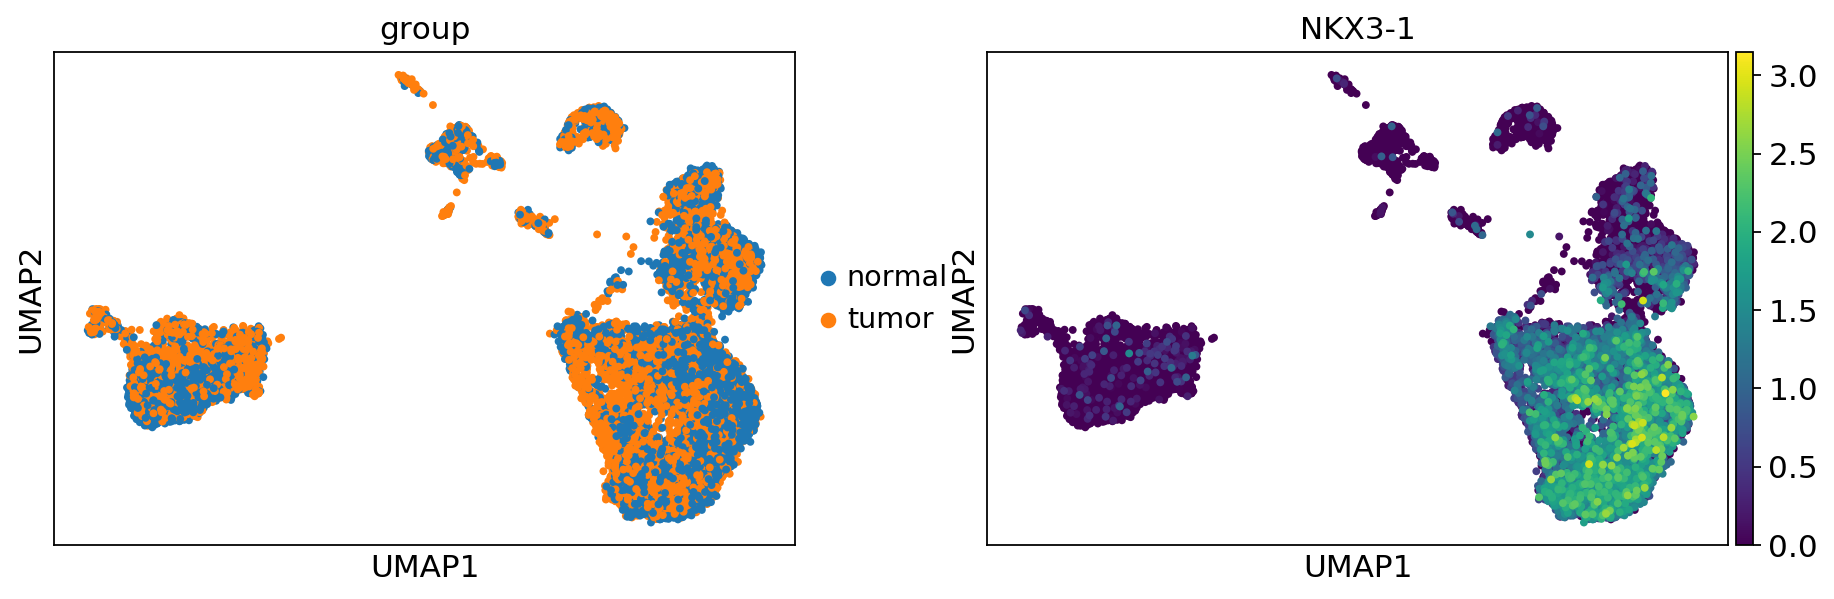

In [2]:
sc.set_figure_params(vector_friendly=True, dpi_save=900, figsize = (6,4))
sc.pl.umap(adata, color = ['group','NKX3-1'], size = 50, save = '/charlie_nkx3.pdf')

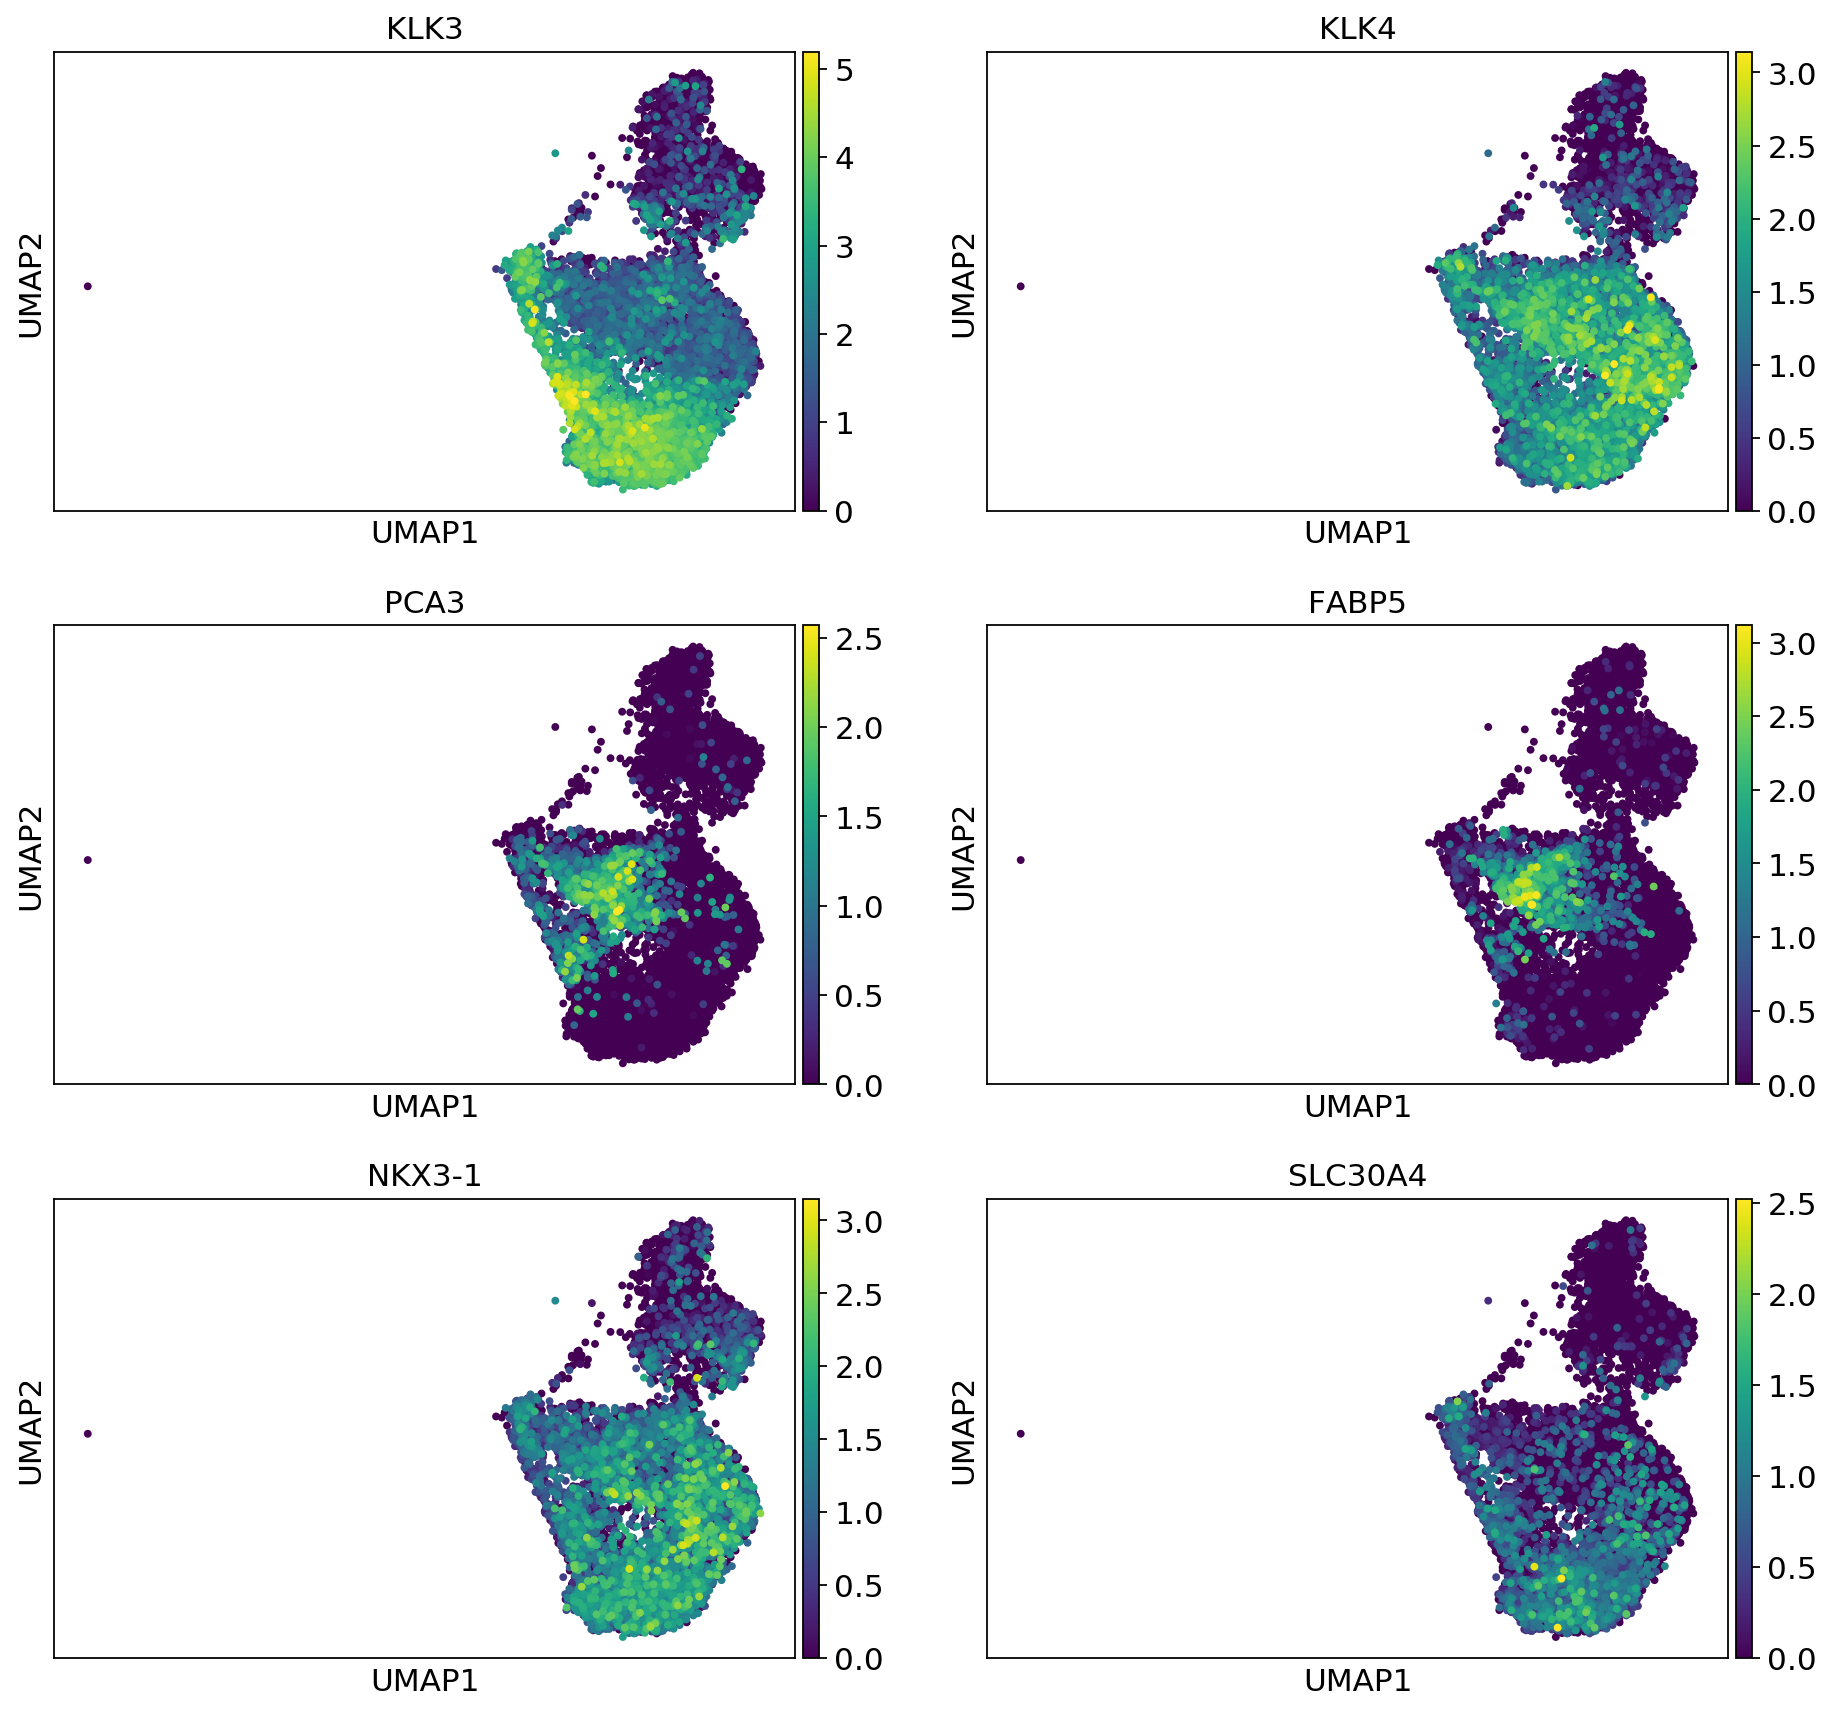

In [2]:
ldata = adata[adata.obs['celltype'].isin(['BE', 'CE', 'HE', 'LE-KLK3', 'LE-KLK4'])]
sc.set_figure_params(vector_friendly=True, dpi_save=900, figsize = (6,4))
sc.pl.umap(ldata, color = ['KLK3', 'KLK4', 'PCA3', 'FABP5', 'NKX3-1','SLC30A4'], size = 50, color_map = 'viridis', ncols = 2, save = '/charlie_markers.pdf')

Trying to set attribute `.obs` of view, making a copy.
... storing 'celltype_group' as categorical


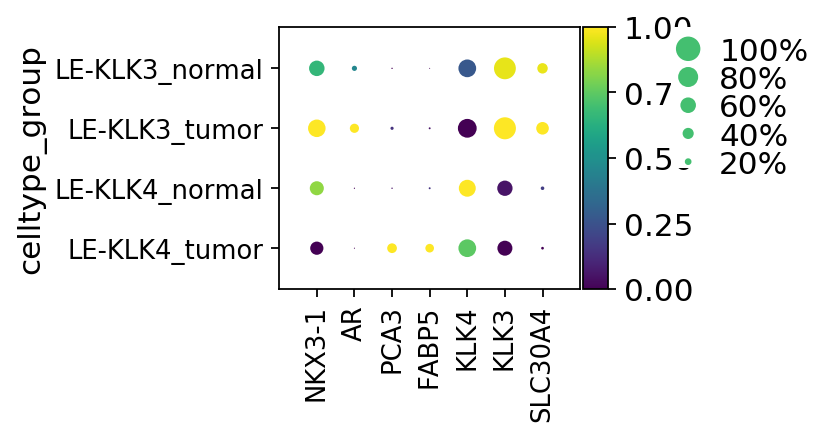

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.4499999999999997, 0, 0.2, 0.5, 0.25])

In [3]:
ldata.obs['celltype_group'] = [c+'_'+g for g,c in zip(ldata.obs['group'], ldata.obs['celltype'])]
ldata = ldata[ldata.obs['celltype'].isin(['LE-KLK3', 'LE-KLK4'])]
sc.pl.dotplot(ldata, ['NKX3-1','AR', 'PCA3', 'FABP5', 'KLK4', 'KLK3', 'SLC30A4'], groupby = 'celltype_group', standard_scale ='var', save = '/charlie_dotplot1.pdf', color_map ='viridis')

... storing 'celltype_group' as categorical


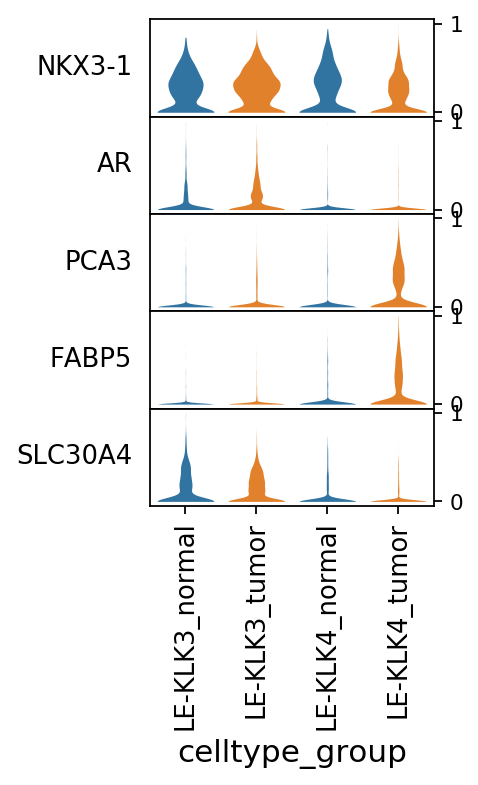

In [7]:
ldata.obs['celltype_group'] = [c+'_'+g for g,c in zip(ldata.obs['group'], ldata.obs['celltype'])]
sc.pl.stacked_violin(ldata, ['NKX3-1', 'AR', 'PCA3', 'FABP5', 'SLC30A4'], groupby = 'celltype_group', standard_scale = 'var', swap_axes = True, palette = ldata.uns['group_colors'], linewidth = 0, figsize = (2.5,4),  save = '/violin_nkx31_pca3_fabp5')

In [9]:
epi = adata[adata.obs['celltype'].isin(['BE','HE','CE','LE-KLK3','LE-KLK4'])]
df = pd.DataFrame(epi.raw.X.toarray())
df.columns = epi.raw.var.index
df.index = epi.obs.index
df['celltype'] = epi.obs['celltype']

In [10]:
df1 = df[['KRT19', 'NKX3-1', 'KLK3', 'KLK4', 'FABP5', 'celltype']]

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
if not os.path.exists('figures/ridgeplot/'):
    os.makedirs('figures/ridgeplot/')

def ridgePlot(df, gene):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    # Initialize the FacetGrid object
    pal = epi.uns['celltype_colors']
    g = sns.FacetGrid(df1, row="celltype", hue="celltype", aspect=5.5, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, gene, clip_on=False, shade=True, alpha=1, lw=0, bw=.2)
    g.map(sns.kdeplot, gene, clip_on=False, color="w", lw=.1, bw=.2)
    g.map(plt.axhline, y=0, lw=1, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="right", va="center", transform=ax.transAxes)

    g.map(label, gene)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.savefig('figures/ridgeplot/'+gene+'.pdf')

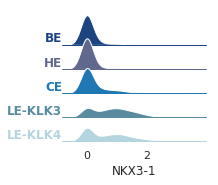

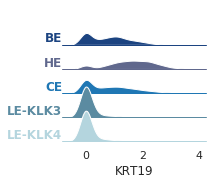

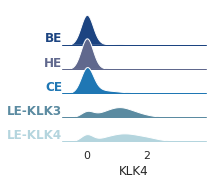

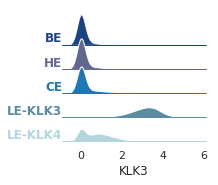

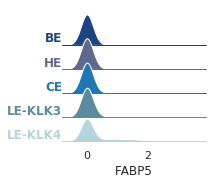

In [14]:
ridgePlot(df1, 'NKX3-1')
ridgePlot(df1, 'KRT19')
ridgePlot(df1, 'KLK4')
ridgePlot(df1, 'KLK3')
ridgePlot(df1, 'FABP5')

Trying to set attribute `.obs` of view, making a copy.
... storing 'celltype_group' as categorical


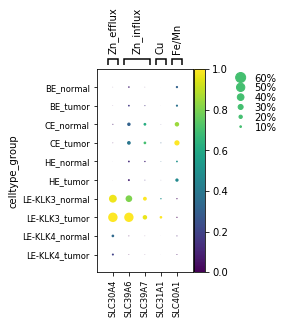

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[1.75, 0, 0.2, 0.5, 0.25])

In [7]:
edata = adata[adata.obs['celltype'].isin(['BE', 'HE', 'CE', 'LE-KLK4', 'LE-KLK3'])]
edata.obs['celltype_group'] = [c+'_'+g for g,c in zip(edata.obs['group'],edata.obs['celltype'])]
metal_ion_transport = {'Zn_efflux':['SLC30A4'], 'Zn_influx':['SLC39A6', 'SLC39A7'], 'Cu':['SLC31A1'], 'Fe/Mn':['SLC40A1']}
sc.pl.dotplot(edata, metal_ion_transport, groupby = 'celltype_group', standard_scale ='var', color_map = 'viridis', save = '/slc_transporters_dotplot.pdf')

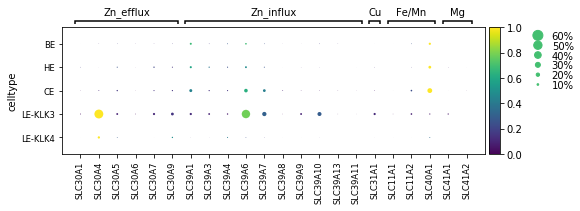

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[7.699999999999999, 0, 0.2, 0.5, 0.25])

In [8]:
metal_ion_transport = {'Zn_efflux':['SLC30A1', 'SLC30A4', 'SLC30A5', 'SLC30A6', 'SLC30A7', 'SLC30A9'], 'Zn_influx':['SLC39A1', 'SLC39A3', 'SLC39A4', 'SLC39A6', 'SLC39A7', 'SLC39A8','SLC39A9', 'SLC39A10', 'SLC39A13', 'SLC39A11'], 'Cu':['SLC31A1'], 'Fe/Mn':['SLC11A1','SLC11A2' ,'SLC40A1'],  'Mg':['SLC41A1','SLC41A2']}
sc.pl.dotplot(edata, metal_ion_transport, groupby = 'celltype', standard_scale ='group', color_map = 'viridis', var_group_rotation = 0, save ='/metal_ion_transporters_dotplot.pdf')

In [9]:
edata = adata[adata.obs['celltype'].isin(['BE', 'HE', 'CE', 'LE-KLK4', 'LE-KLK3'])]

Trying to set attribute `.obs` of view, making a copy.
... storing 'celltype_group' as categorical


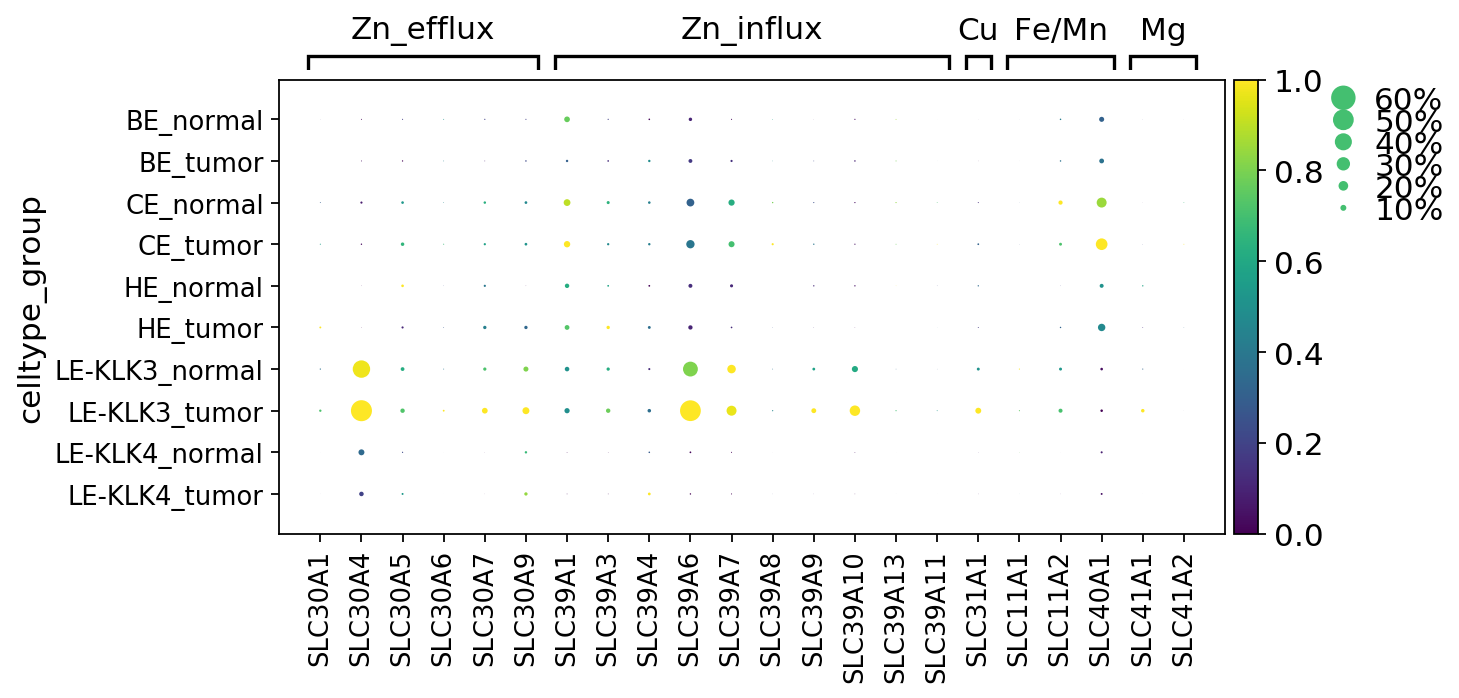

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[7.699999999999999, 0, 0.2, 0.5, 0.25])

In [10]:
edata.obs['celltype_group'] = [c+'_'+g for g,c in zip(edata.obs['group'],edata.obs['celltype'])]
metal_ion_transport = {'Zn_efflux':['SLC30A1', 'SLC30A4', 'SLC30A5', 'SLC30A6', 'SLC30A7', 'SLC30A9'], 'Zn_influx':['SLC39A1', 'SLC39A3', 'SLC39A4', 'SLC39A6', 'SLC39A7', 'SLC39A8','SLC39A9', 'SLC39A10', 'SLC39A13', 'SLC39A11'], 'Cu':['SLC31A1'], 'Fe/Mn':['SLC11A1','SLC11A2' ,'SLC40A1'],  'Mg':['SLC41A1','SLC41A2']}
sc.pl.dotplot(edata, metal_ion_transport, groupby = 'celltype_group', standard_scale ='var', color_map = 'viridis', var_group_rotation = 0, save ='/metal_ion_transporters_tumor_normal_dotplot.pdf')

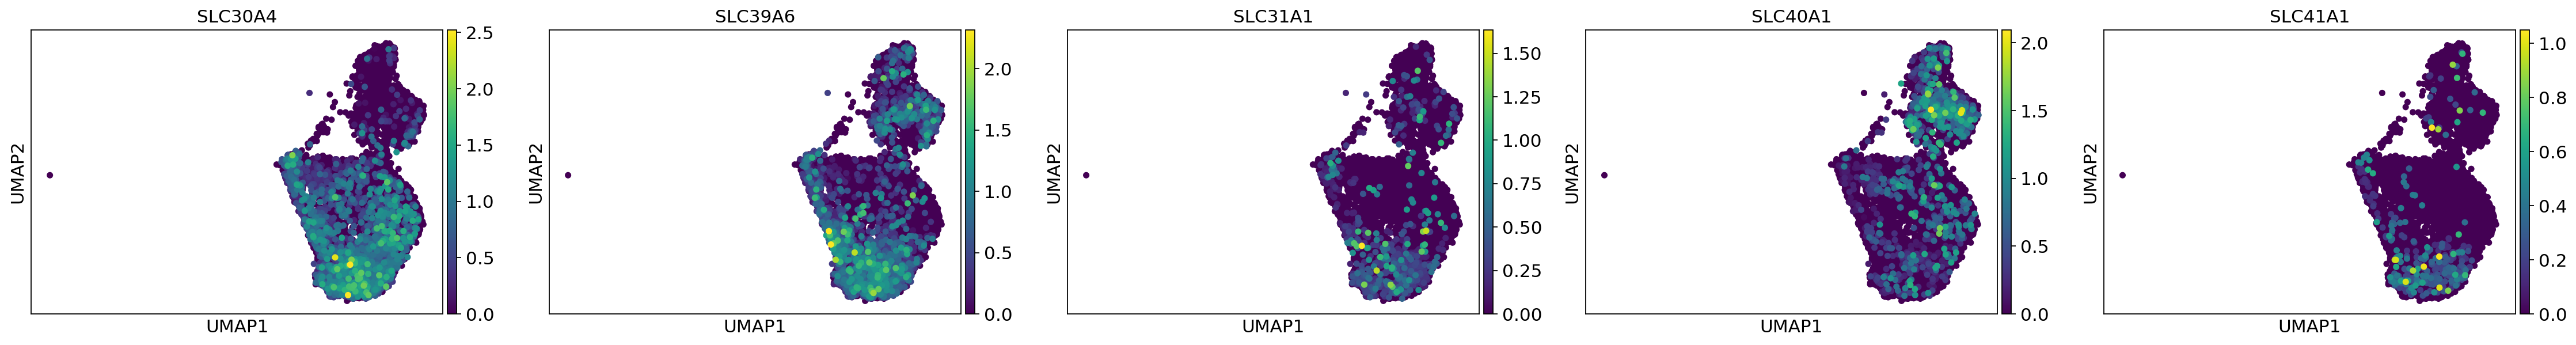

In [3]:
sc.set_figure_params(vector_friendly=True, dpi_save=900, figsize = (6,4))
sc.pl.violin(edata, color = ['SLC30A4', 'SLC39A6', 'SLC31A1', 'SLC40A1', 'SLC41A1'], color_map = 'viridis', ncols = 5, size = 100, save = '/slc_transporters.pdf')

Trying to set attribute `.obs` of view, making a copy.
... storing 'celltype_group' as categorical


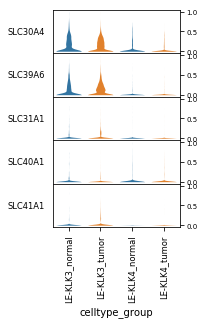

In [10]:
ldata = adata[adata.obs['celltype'].isin(['LE-KLK3', 'LE-KLK4'])]
ldata.obs['celltype_group'] = [c+'_'+g for g,c in zip(ldata.obs['group'], ldata.obs['celltype'])]
sc.pl.stacked_violin(ldata, ['SLC30A4', 'SLC39A6', 'SLC31A1', 'SLC40A1', 'SLC41A1'], groupby = 'celltype_group', standard_scale = 'var', swap_axes = True, palette = ldata.uns['group_colors'], linewidth = 0, figsize = (2.5,4),  save = '/violin_transporters.pdf')

Trying to set attribute `.obs` of view, making a copy.
... storing 'celltype_group' as categorical


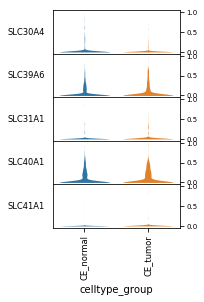

In [5]:
cdata = adata[adata.obs['celltype'].isin(['CE', 'CE'])]
cdata.obs['celltype_group'] = [c+'_'+g for g,c in zip(cdata.obs['group'], cdata.obs['celltype'])]
sc.pl.stacked_violin(cdata, ['SLC30A4', 'SLC39A6', 'SLC31A1', 'SLC40A1', 'SLC41A1'], groupby = 'celltype_group', standard_scale = 'var', swap_axes = True, palette = cdata.uns['group_colors'], linewidth = 0, figsize = (2.5,4),  save = '/violin_transporters_ce.pdf')

In [6]:
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
# run GSEA of tumor KLK3 and KLK4 metabolism
def rankList(deg_file, remove_ribo_mito = False):
    # read in the files and do some ranking calculations
    deg = pd.read_csv(deg_file, sep = '\t', index_col = 0)
    if remove_ribo_mito:
        # remove ribosomal and mitochondrial genes
        deg = deg[~deg.index.str.contains('RPS|RPL|MT-')]

    # convert to negative log10 pval
    deg['neglog10pval'] = [-1*np.log10(p) for p in deg['pvals']]
    # convert inf values to max machine number
    try:
        deg['neglog10pval'].replace(np.inf, -1*np.log10(10**-308), inplace = True)
    except:
        pass
    try:    
        deg['neglog10pval'].replace(-np.inf, -1*np.log10(10**308), inplace = True)
    except:
        pass
    deg['rank'] = [p*np.sign(lfc) for p, lfc in zip(deg['neglog10pval'], deg['logfoldchanges'])]
    deg = deg.reset_index(drop = False)
    return(deg[['index', 'rank']])

In [10]:
# quickly prep the files
klk3 = rankList('out/DEG/tumor vs normal/LE-KLK3_tumor_vs_normal.txt', True)
klk4 = rankList('out/DEG/tumor vs normal/LE-KLK4_tumor_vs_normal.txt', True)

In [11]:
# run preranked gsea
import gseapy as gp
pre_res_klk3 = gp.prerank(rnk=klk3, 
                     gene_sets='./dataset/Hallmarks_metabolism_genesets.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res_klk4 = gp.prerank(rnk=klk4, 
                     gene_sets='./dataset/Hallmarks_metabolism_genesets.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)

2020-03-29 14:01:48,315 Parsing data files for GSEA.............................
2020-03-29 14:01:48,561 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-03-29 14:01:48,562 0005 gene_sets used for further statistical testing.....
2020-03-29 14:01:48,563 Start to run GSEA...Might take a while..................
2020-03-29 14:02:00,000 Start to generate gseapy reports, and produce figures...
2020-03-29 14:02:00,022 Congratulations. GSEApy runs successfully................

2020-03-29 14:02:00,033 Parsing data files for GSEA.............................
2020-03-29 14:02:00,265 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-03-29 14:02:00,266 0005 gene_sets used for further statistical testing.....
2020-03-29 14:02:00,267 Start to run GSEA...Might take a while..................
2020-03-29 14:02:02,054 Start to generate gseapy reports, and produce figures...
2020-03-29 14:02:02,063 Congratulations. GSEApy runs successfully............

In [12]:
pre_res_klk3.res2d.to_csv('out/GSEA/KLK3_tumor_vs_normal_hallmarkmetabolism_gsea.txt', sep='\t')
pre_res_klk4.res2d.to_csv('out/GSEA/KLK4_tumor_vs_normal_hallmarkmetabolism_gsea.txt', sep='\t')

Trying to set attribute `.obs` of view, making a copy.
... storing 'celltype_group' as categorical


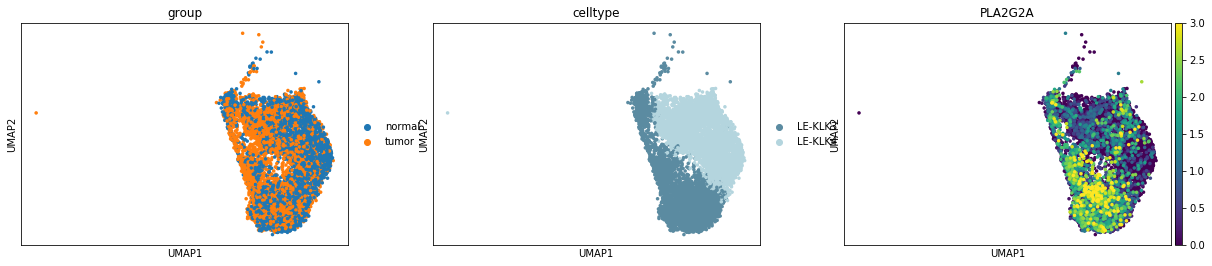

In [19]:
ldata = adata[adata.obs['celltype'].isin(['LE-KLK3', 'LE-KLK4'])]
ldata.obs['celltype_group'] = [c+'_'+g for g,c in zip(ldata.obs['group'], ldata.obs['celltype'])]
sc.pl.umap(ldata, color = ['group', 'celltype', 'PLA2G2A'], size = 50, vmax = 3)

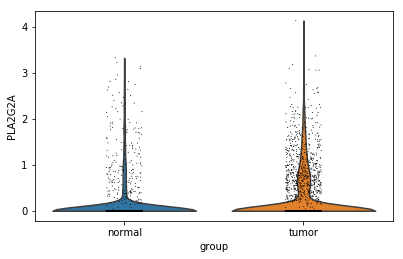

In [25]:
sc.pl.violin(ldata[ldata.obs['celltype'] == 'LE-KLK4'], ['PLA2G2A'], groupby = 'group', use_raw = True)

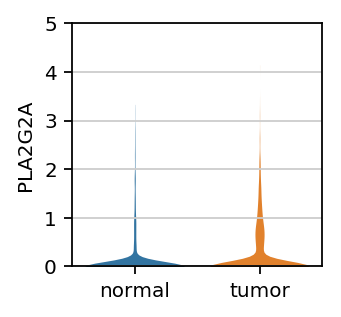

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(2,2))
plt.ylim(0,5)
ax = sns.violinplot()
sc.pl.violin(ldata[ldata.obs['celltype'] == 'LE-KLK4'], ['PLA2G2A'], ax = ax, groupby = 'group', size = 0, standard_scale = 'var', palette = adata.uns['group_colors'], linewidth = 0, rotation = 0, save = '/PLA2G2A.pdf')